<a href="https://colab.research.google.com/github/Loinen/geodata_analysis/blob/main/lab2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты и загрузка данных


In [5]:
# for colab
# ! pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 20.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import scipy.stats as scs

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

    TEMP - Mean temperature (.1 Fahrenheit)
    SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9 (.1 mb)
    WDSP – Mean wind speed (.1 knots)

In [18]:
random.seed(42)
original_data = pd.read_csv("https://raw.githubusercontent.com/Loinen/geodata_analysis/main/data/data_spb.csv", index_col=1, na_values='NA', usecols=['STATION', 'DATE', 'TEMP', 'SLP'])
original_data

,STATION,SLP,TEMP
DATE,,,
1990-02-03,26060099999,1010.5,34.3
1990-02-13,26060099999,1002.7,31.8
1990-04-29,26060099999,1014.9,50.4
1990-01-01,26063099999,1020.3,27.5
1990-01-02,26063099999,1020.4,22.2
...,...,...,...
2019-12-31,26072099999,993.5,35.8
2020-01-01,26063099999,9999.9,33.1
2020-01-02,26063099999,9999.9,38.7


In [19]:
original_data = original_data.loc[original_data.STATION == 26063099999]
original_data = original_data.drop(columns='STATION')

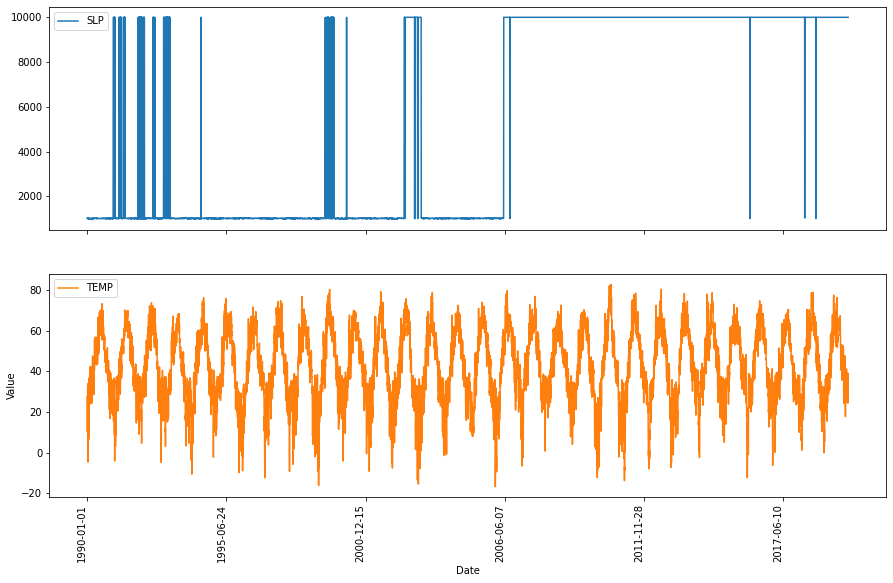

In [20]:
original_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()
# we can see a lot of gaps at the end

In [59]:
# удаление пропущенных значений + убираем все после 2006 года
original_data = original_data.loc[:'2006-01-01']

data = original_data.copy()
missing_vals = data.loc[data.SLP==9999.9]
data = data.replace(9999.9, np.nan, regex=True)
data = data.dropna(subset=['SLP'])

In [ ]:
data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
data.shape

(5375, 2)

In [ ]:
missing_vals.shape

(469, 2)

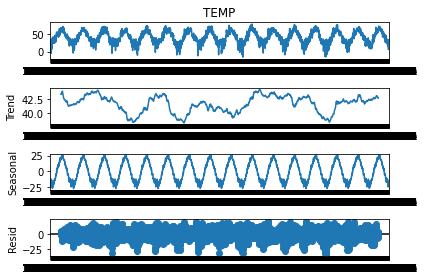

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

missing_vals['SLP'] = data['SLP'].median()

data = pd.concat([data, missing_vals])
data = data.sort_index()

scaler = MinMaxScaler()
# data[data.columns] = scaler.fit_transform(data[data.columns])

result = seasonal_decompose(data["TEMP"], model='additive', period=365)
result.plot()
plt.show()
seas = result.seasonal
trend = result.trend
resid = result.resid

In [ ]:
data['TEMP2']  = data.TEMP - data.TEMP.shift(180)
# data['TEMP2']  = data.TEMP - data.TEMP.shift(365)

plt.figure(figsize=(15,10))
data = data.dropna()
print("Dickey-Fuller test: Statistic value=%f" % sm.tsa.stattools.adfuller(data.TEMP2)[0])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.TEMP2)[1])
result = sm.tsa.seasonal_decompose(data.TEMP2, model='additive', period=365)
seas = result.seasonal
trend = result.trend
result.plot()

In [ ]:
plt.figure(figsize=(15,7))
data.TEMP2[:365].plot()

Критерий Дики-Фуллера: p=0.000000
Критерий Дики-Фуллера: p=0.000000


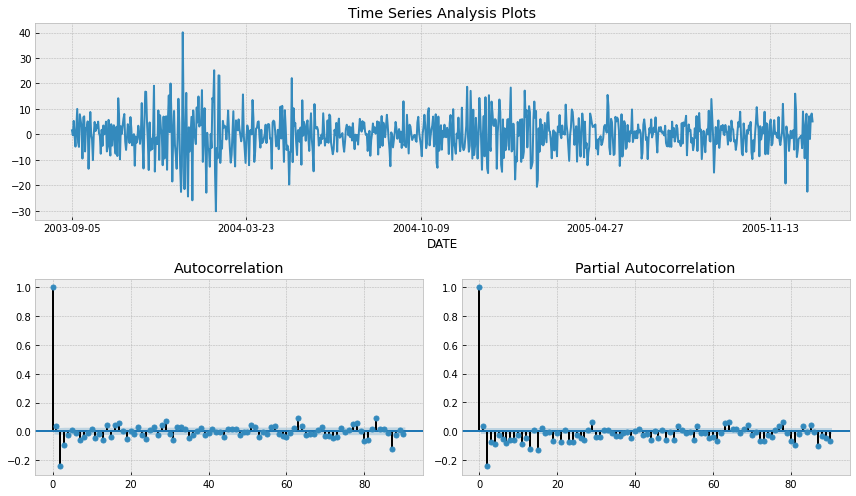

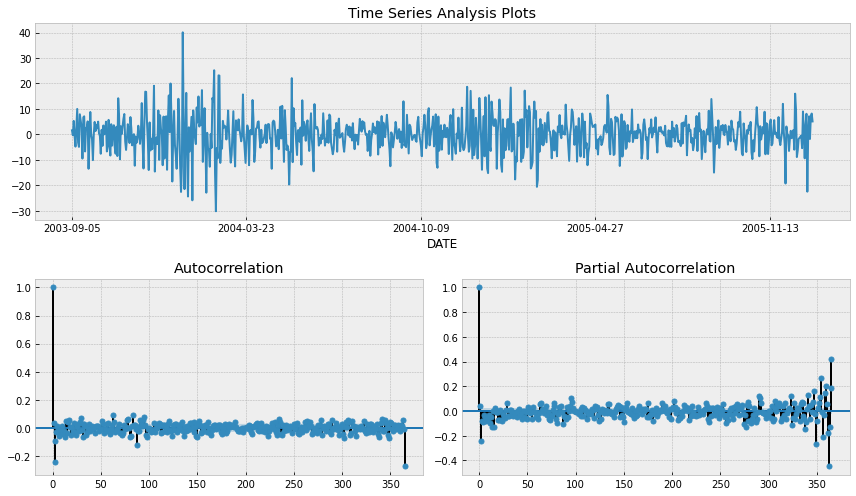

In [74]:
data['TEMP2']  = data.TEMP - data.TEMP.shift(365)
data['TEMP2']  = data.TEMP2 - data.TEMP2.shift(1)

tsplot(data['TEMP2'][-850:], lags=90)
tsplot(data['TEMP2'][-850:], lags=365)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Test RMSE: 6.154


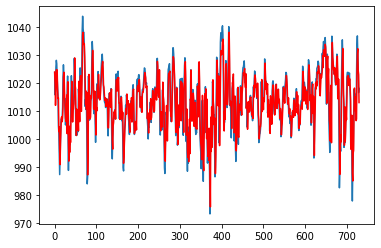

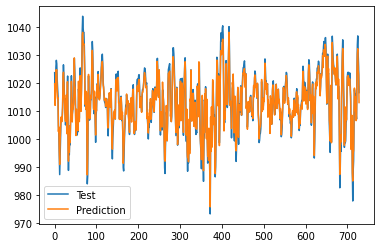

rmse 2.185085591797813
mae 1.682725966841395


In [88]:
data2 = data.dropna(subset=['TEMP2'])
pressure = data2['SLP'].values
temp = data2['TEMP2'].values
window = 30

# prediction_size = 100
# train_size = 100

# X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
# pressure[len(pressure)-prediction_size:]
# exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
# temp[len(temp)-prediction_size:]
# print(X_train_autoreg)

test_size = 730
X_train_autoreg, X_test_autoreg = pressure[1:len(pressure)-test_size], pressure[len(pressure)-test_size:]
exog_train, exog_test = temp[1:len(temp)-test_size], temp[len(temp)-test_size:]

predictions = autoreg(X_train_autoreg, X_test_autoreg, window, 'n', exog_train, exog_test)

In [89]:
def autoreg(X_train_autoreg, X_test_autoreg, lags, trend, exog_train=None, exog_test=None):    
    
    if exog_train is None:
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=False)
    else:                
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend, exog=exog_train)
        autoreg_model_fit = autoreg_model.fit()
        coef = autoreg_model_fit.params
        window = lags 

        history = X_train_autoreg[len(X_train_autoreg)-window:]
        history = [history[i] for i in range(len(history))]
        predictions = list()
        for t in range(len(X_test_autoreg)):
          length = len(history)
          lag = [history[i] for i in range(length-window,length)]
          yhat = 0
          for d in range(window):
            yhat += coef[d] * lag[window-d-1]
          obs = X_test_autoreg[t]
          predictions.append(yhat)
          history.append(obs)
        rmse = sqrt(mean_squared_error(X_test_autoreg, predictions))
        print('Test RMSE: %.3f' % rmse)

        # predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
        #                         end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True, exog_oos=exog_test)
    
    rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
    mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])
    
    fig, ax = plt.subplots()

    ax.plot(X_test_autoreg[:-1], label="Test")
    ax.plot(predictions[1:], label="Prediction")

    ax.legend()
    plt.show()
    
    print("rmse", rmse)
    print("mae", mae)
    
    return predictions

# Медиана (+проверка на рандомных пропусках)

In [ ]:
missing_vals['SLP'] = data['SLP'].median()

filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

[]

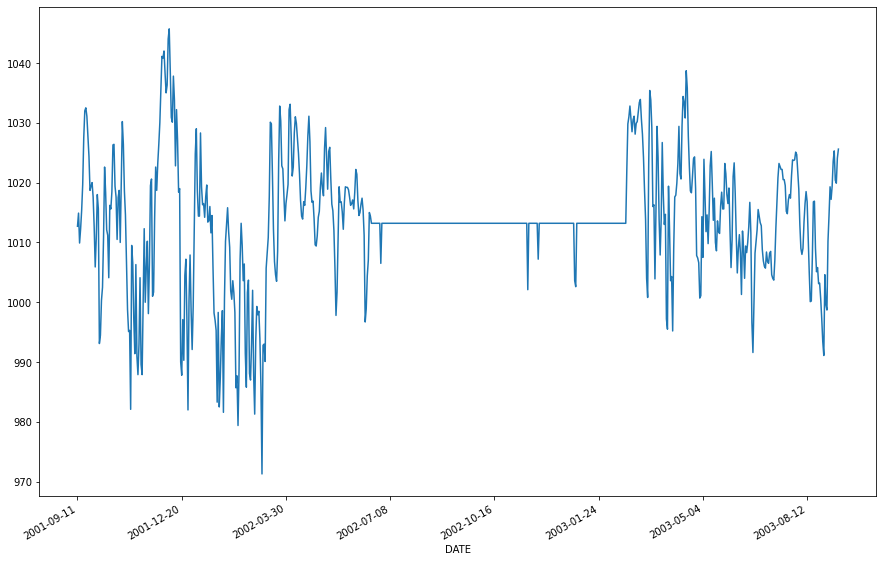

In [ ]:
filled_data.SLP['2001-09-11':'2003-09-11'].plot(subplots=True, figsize=(15, 10))
plt.plot()

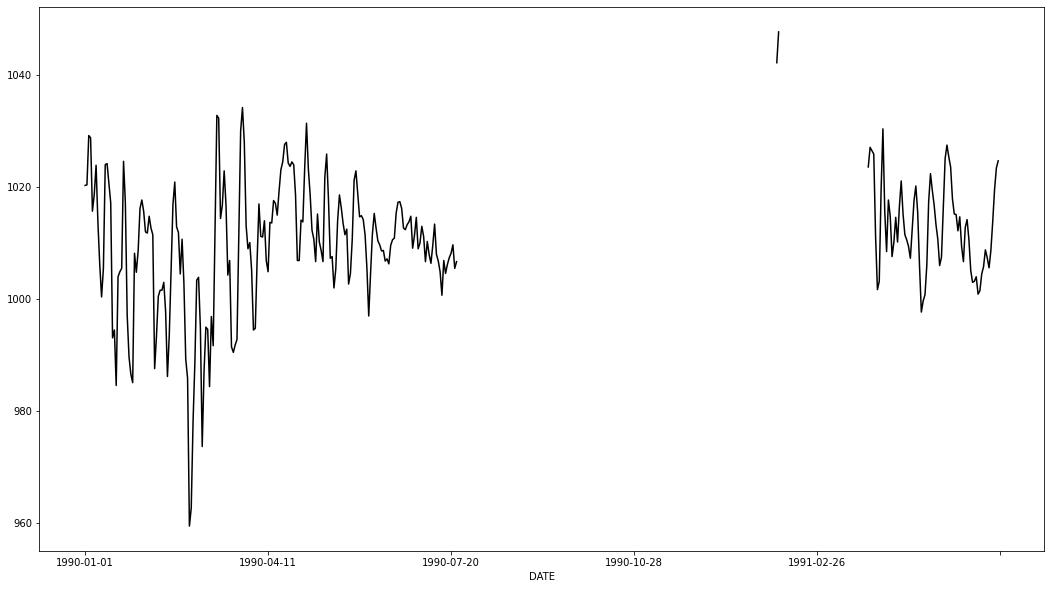

In [ ]:
random_missing = data.copy()
random_missing = random_missing[:500]

index_df = missing_vals['2001-09-11':'2003-09-11'].copy()
index_df.index = pd.to_datetime(index_df.index)
index_df = index_df.shift(-(12*365)+np.random.randint(1,6*30), freq='D') # делаем такой же пропуск в рандомном месте +-6 месяцев

gaps_index = index_df.index.strftime("%Y-%m-%d").to_list()

random_missing.at[random_missing.index.intersection(gaps_index), "SLP"] = np.nan
random_missing = random_missing.sort_index()
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')


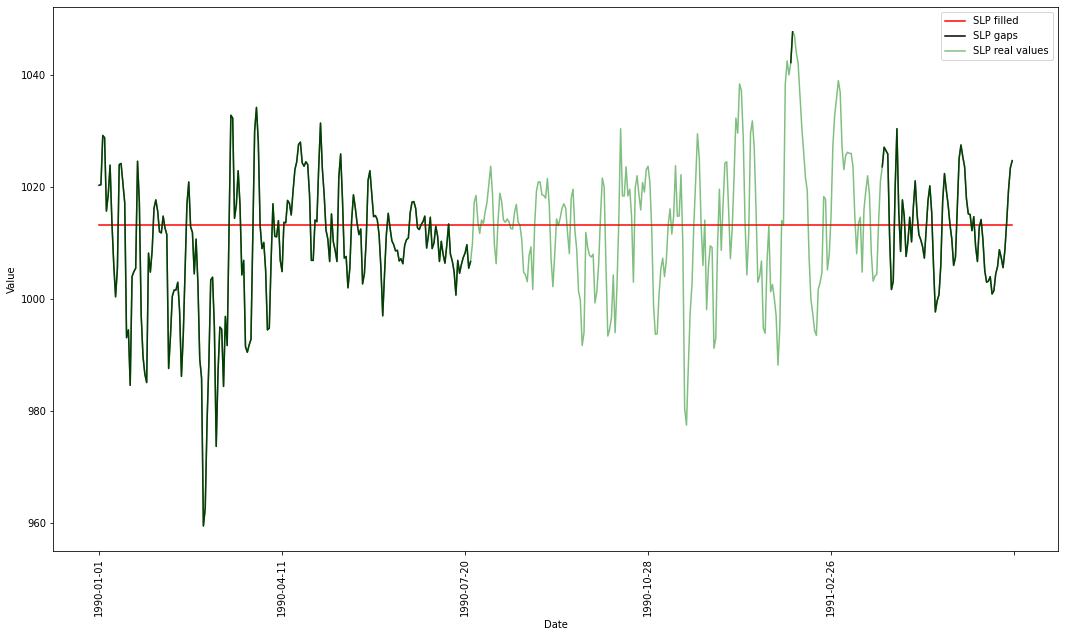

random gaps rmse:  11.727464346566997 mae:  8.685800000000002


In [ ]:
filled = random_missing.copy()
filled['SLP'] = data['SLP'].median()

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

# Приводим ряд к стационарному

In [10]:
# рисует ряд, автокорреляцию
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000000


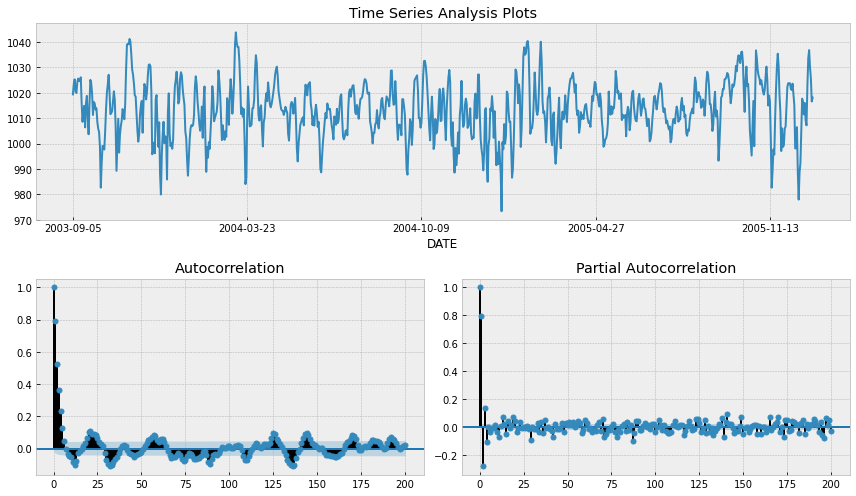

In [79]:
tsplot(filled_data['SLP'][-850:], lags=40)

На автокорреляционной функции сезонность, ее нужно убрать.

Критерий Дики-Фуллера: p=0.000000


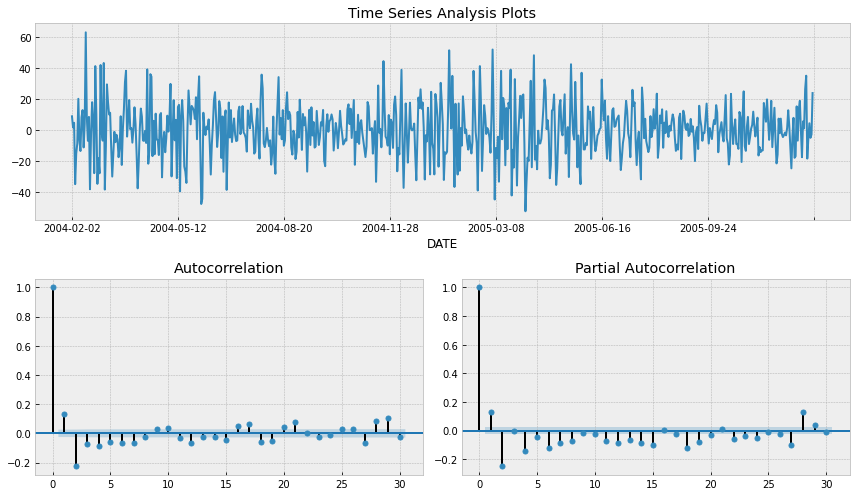

In [ ]:
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
tsplot(filled_data.SLP[-700:], lags=30)

Еще нужно убрать значимые лаги.

Критерий Дики-Фуллера: p=0.000000


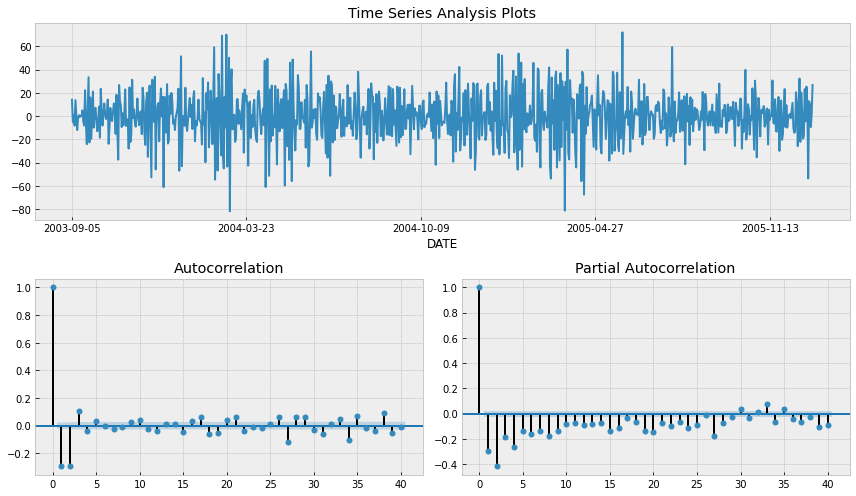

In [ ]:
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
tsplot(filled_data.SLP[-850:], lags=40)

Теперь наш ряд стационарный.

# Строим авторегрессию

In [ ]:
pressure = filled_data['SLP'].values

In [11]:
def autoreg(X_train_autoreg, X_test_autoreg, lags, trend, exog_train=None, exog_test=None):    
    
    if exog_train is None:
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=False)
    else:                
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend, exog=exog_train)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True, exog_oos=exog_test)
    
    rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
    mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])
    
    fig, ax = plt.subplots()

    ax.plot(X_test_autoreg[:-1], label="Test")
    ax.plot(predictions[1:], label="Prediction")

    ax.legend()
    plt.show()
    
    print("rmse", rmse)
    print("mae", mae)
    
    return predictions

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


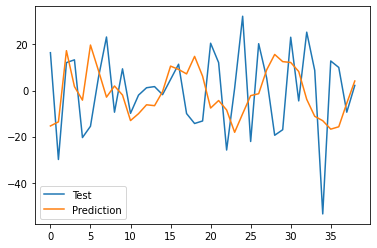

rmse 20.784388934257446
mae 17.361707320760303


In [ ]:
prediction_size = 40
train_size = 50

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]

predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


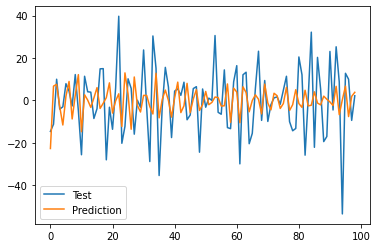

rmse 15.625320915699609
mae 12.043974358892022


In [ ]:
prediction_size = 100
train_size = 100

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]

predictions = autoreg(X_train_autoreg, X_test_autoreg, 35, 'n')

# Добавляем температурный ряд, его тоже надо сделать стационарным

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Критерий Дики-Фуллера: p=0.000000


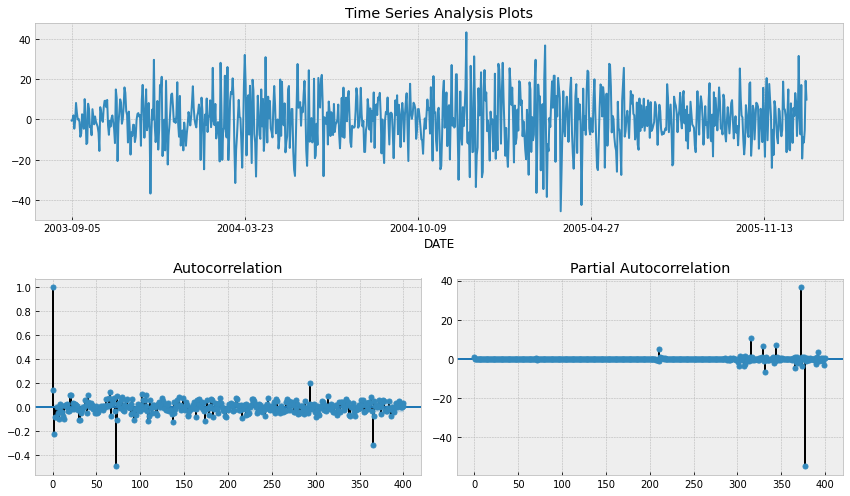

In [ ]:
tsplot(filled_data['TEMP'][-850:], lags=400)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Критерий Дики-Фуллера: p=0.000000


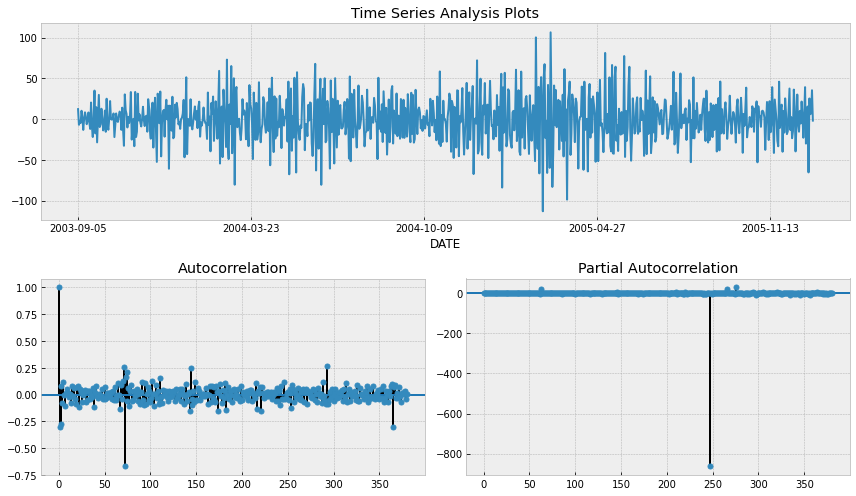

In [ ]:
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)
tsplot(filled_data.TEMP[-850:], lags=380)

Критерий Дики-Фуллера: p=0.000000


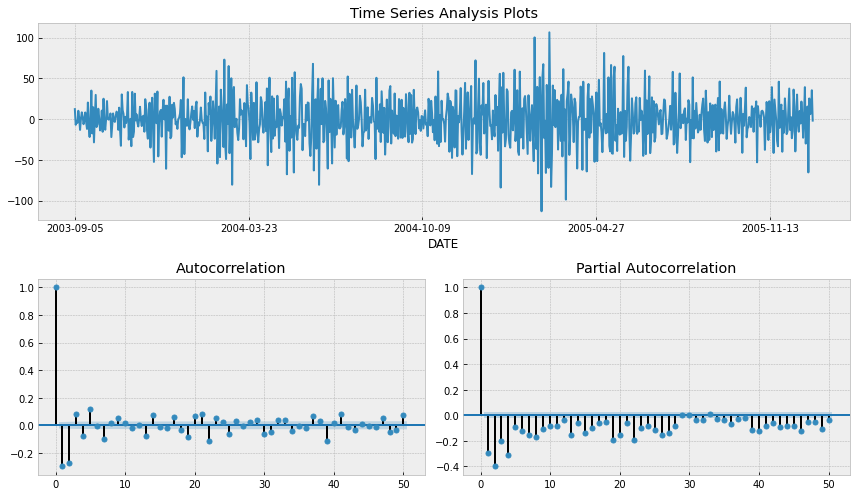

In [ ]:
tsplot(filled_data.TEMP[-850:], lags=50)

In [ ]:
temp = filled_data['TEMP'].values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


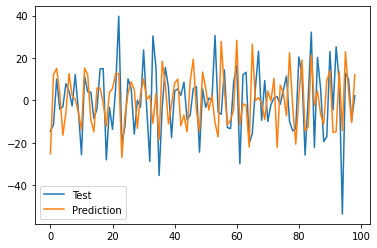

rmse 16.060116255618393
mae 13.059455558845073


In [ ]:
prediction_size = 100
train_size = 100

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]

predictions = autoreg(X_train_autoreg, X_test_autoreg, 29, 'n', exog_train, exog_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


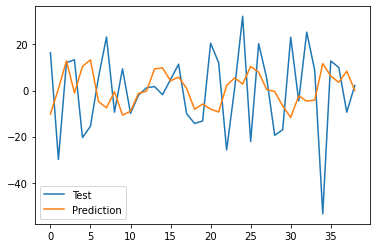

rmse 20.990954158188497
mae 16.005620193039938


In [ ]:
prediction_size = 40
train_size = 40

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]

predictions = autoreg(X_train_autoreg, X_test_autoreg, 10, 'n', exog_train, exog_test)

# Пробуем на участке с пропусками

In [ ]:
pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


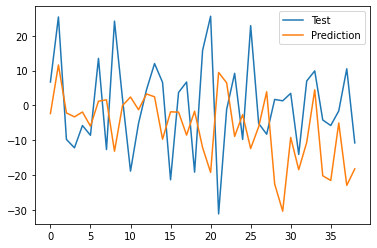

rmse 18.98981725804371
mae 15.112003293715434


In [ ]:
prediction_size = 40
train_size = 40

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]

predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

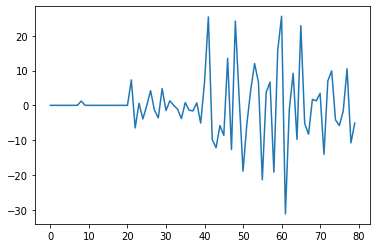

In [ ]:
plt.plot(pressure[-80:])

# Линейная интерполяция (проверка на рандомных пропусках)

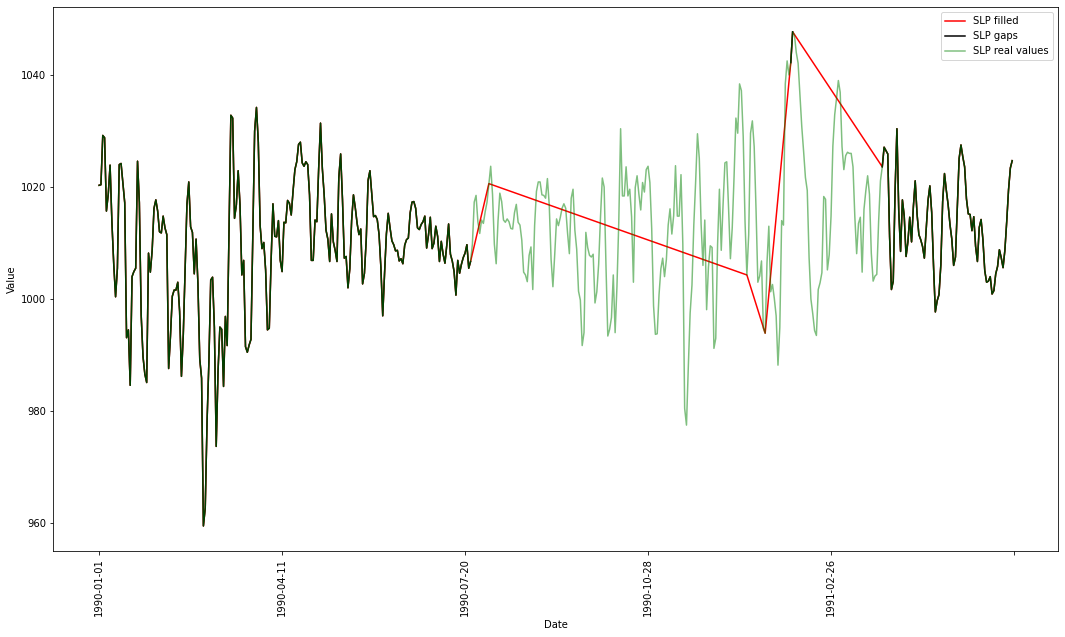

random gaps rmse:  9.795409206562155 mae:  4.878696112317274


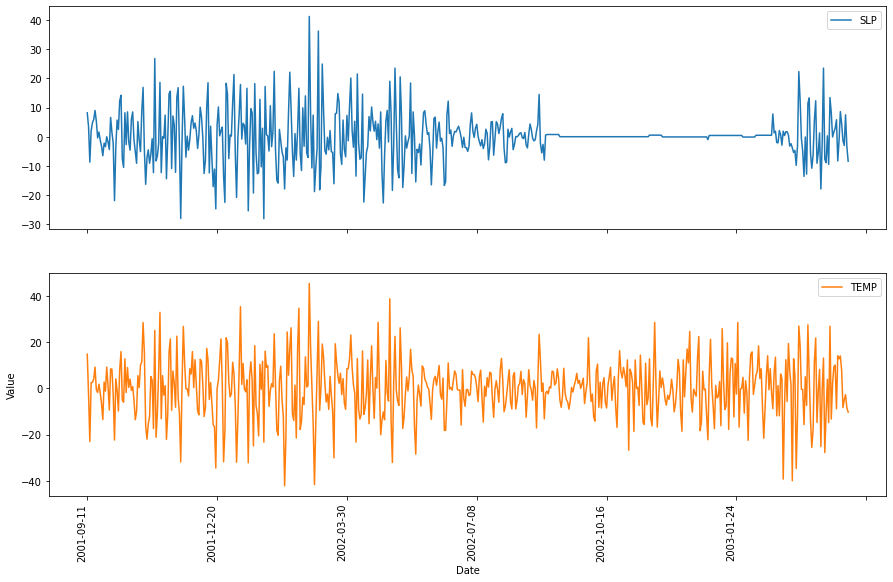

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


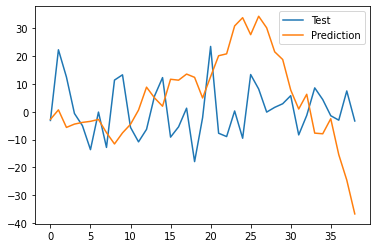

rmse 19.02874603465401
mae 15.599406532848024


In [ ]:
missing_nan = original_data.copy()
missing_nan = missing_nan.replace(9999.9, np.nan, regex=True)

filled = random_missing.copy()
filled['SLP'] = filled[['SLP']].interpolate(method='linear')['SLP']

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

missing_interpolate = missing_nan[['SLP']].interpolate(method='linear')['SLP']
missing_vals['SLP'] = missing_interpolate

filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)

pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

prediction_size = 40
train_size = 40

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

# Интерполяция сплайнами

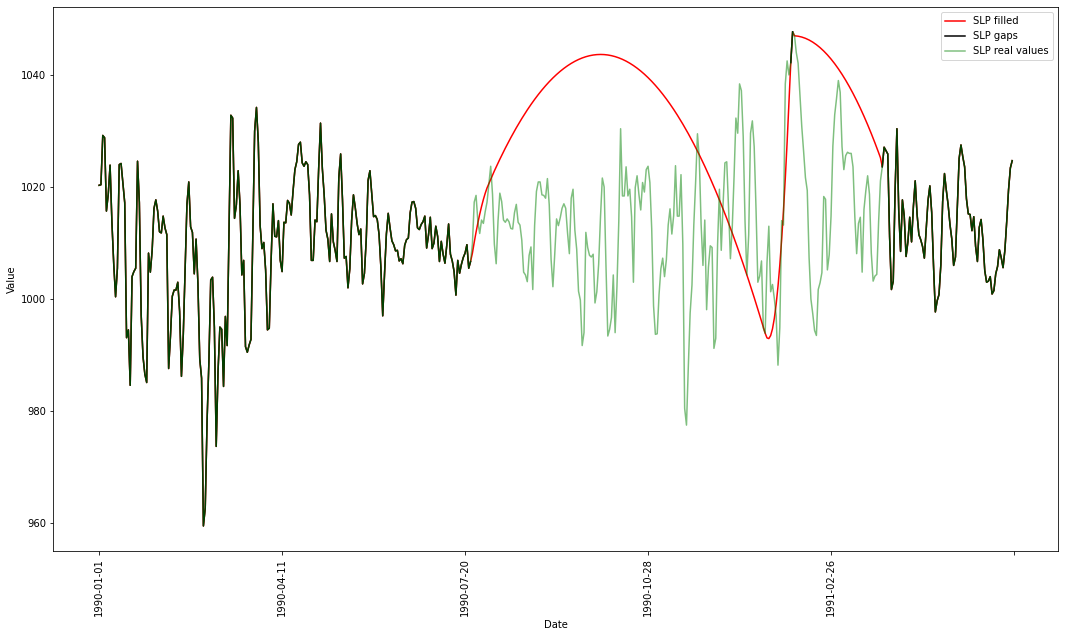

random gaps rmse:  16.451315886405308 mae:  9.270274952234125


In [ ]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = s.interpolate(method='spline', order=2).values

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

In [ ]:
missing_spline = missing_nan.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=3).values
missing_vals['SLP'] = missing_spline

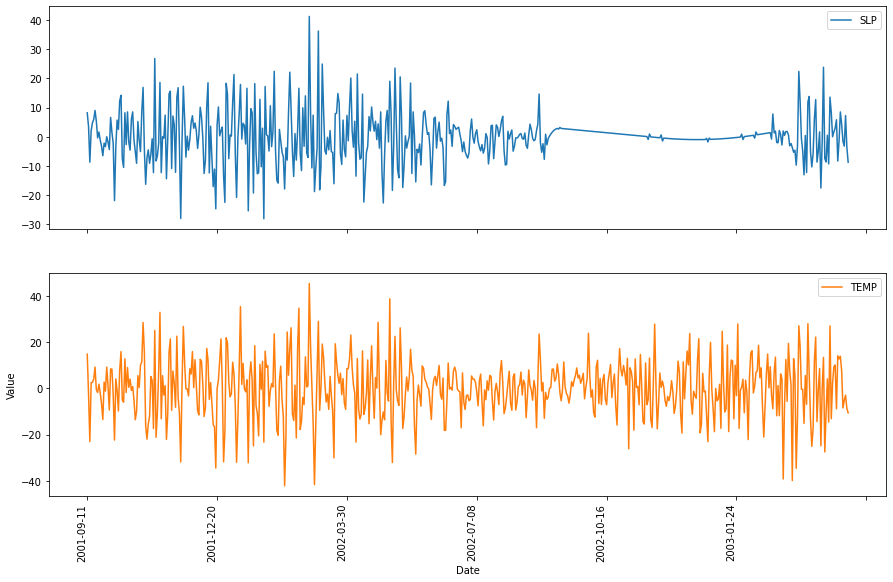

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


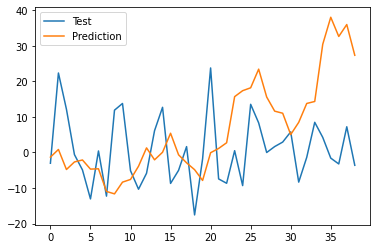

rmse 16.737989429342353
mae 13.423415004305426


In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)

pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

#<h2>KNN</h2>

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

missing_knn = missing_nan.copy()
missing_knn['SLP'] = imputer.fit_transform(missing_knn)
missing_vals['SLP'] = missing_knn

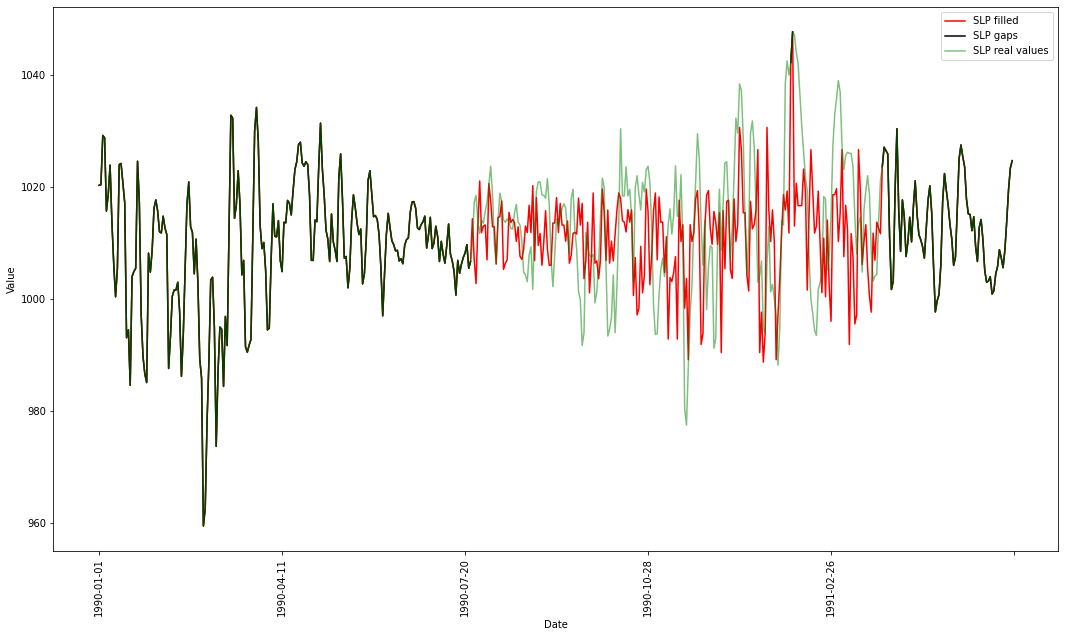

random gaps rmse:  8.26646666424725 mae:  4.354533333333331


In [ ]:
filled = random_missing.copy()
filled['SLP'] = imputer.fit_transform(filled)

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

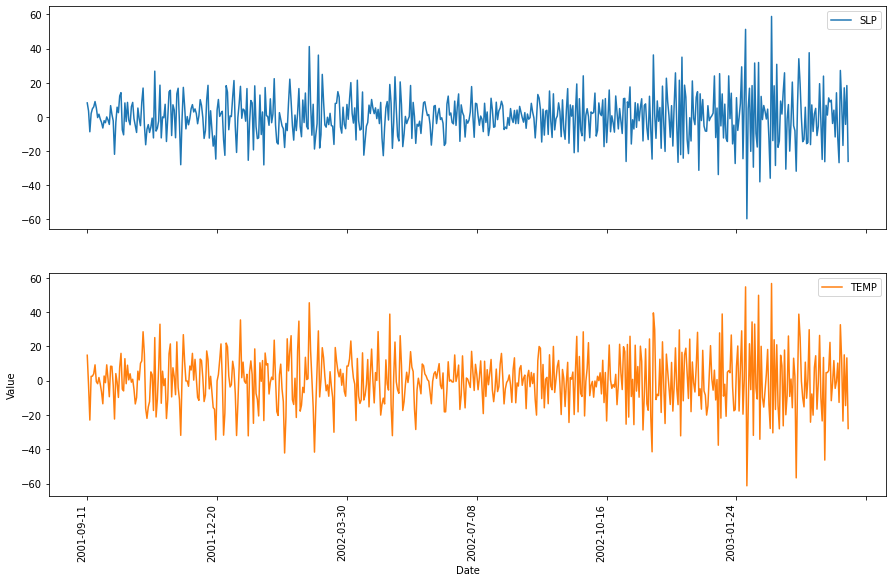

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


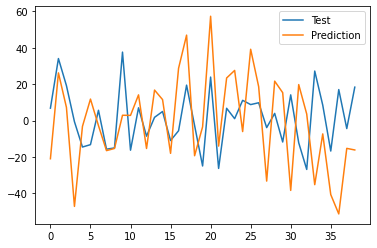

rmse 27.465965462899785
mae 22.706884843615892


In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)

pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

# Итеративное заполнение

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_inter = missing_nan.copy()
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data.dropna())

missing_inter['SLP'] = imp_mean.transform(missing_inter)
missing_vals['SLP'] = missing_inter

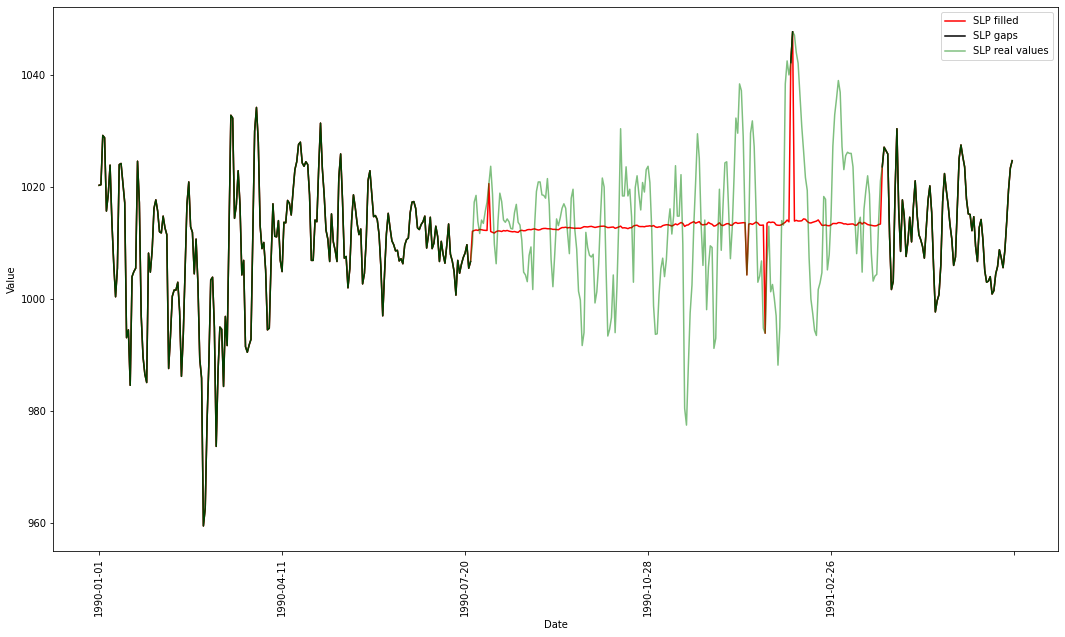

random gaps rmse:  7.69414816680912 mae:  3.9250166656597667


In [ ]:
filled = random_missing.copy()
filled['SLP'] = imp_mean.transform(filled)

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

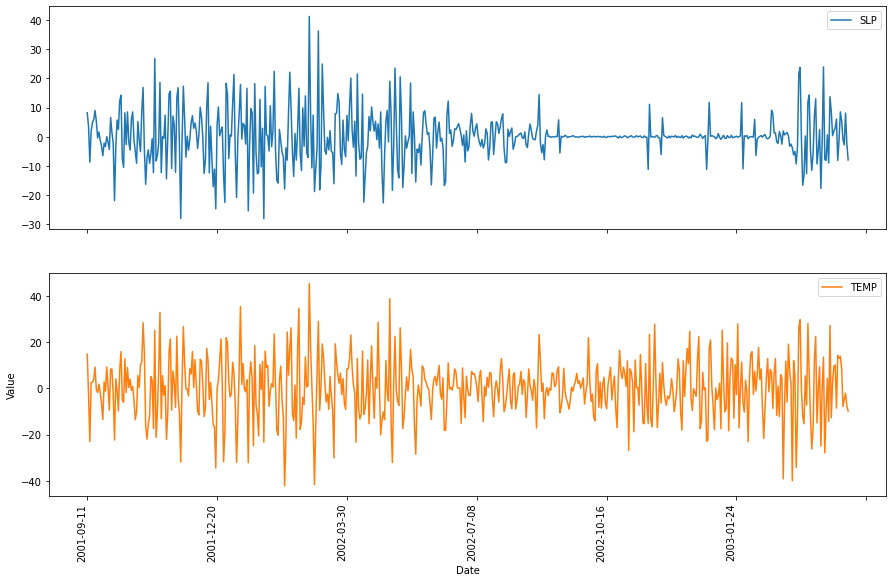

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


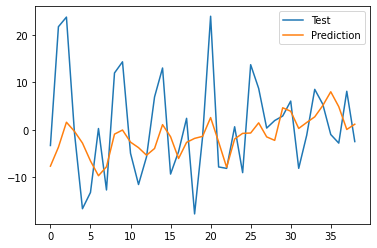

rmse 9.770915278758256
mae 7.509555437486786


In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)

pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

#<h2>Использование фильтра Савицкого-Голэя</h2>

In [ ]:
from scipy.signal import savgol_filter

missing_savgol = missing_nan.copy()
s = pd.Series(missing_savgol["SLP"].values)

missing_savgol['SLP'] = savgol_filter(s.interpolate(method='linear', order=1).values,mode='nearest', window_length=7, polyorder=2)
missing_vals['SLP'] = missing_savgol

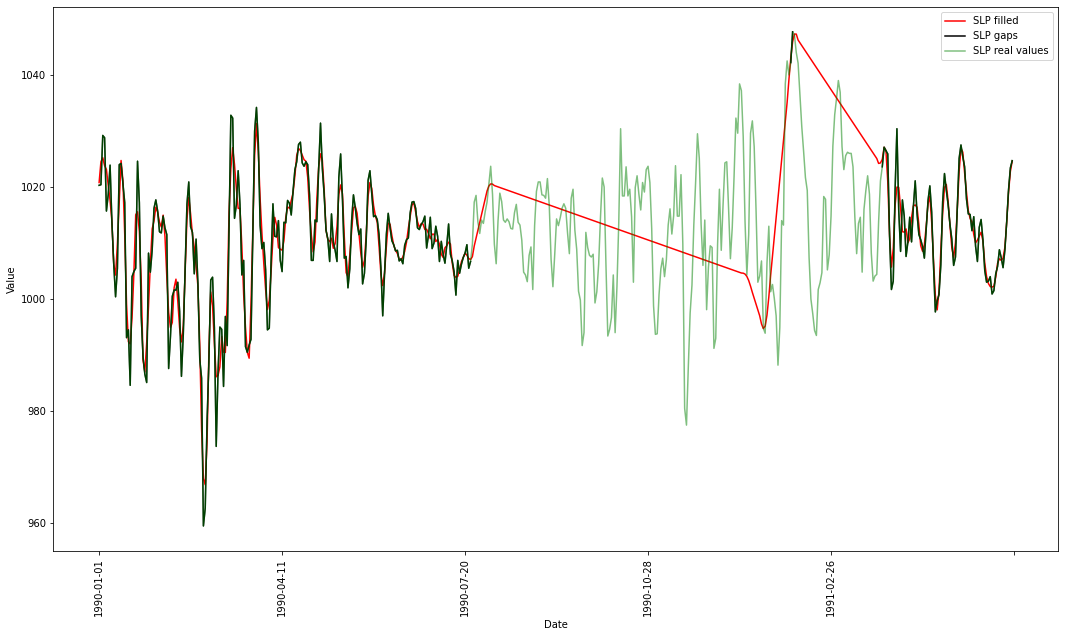

random gaps rmse:  10.13537185028411 mae:  6.299100087808261


In [ ]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = savgol_filter(s.interpolate(method='linear', order=1).values,mode='nearest', window_length=7, polyorder=2)

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

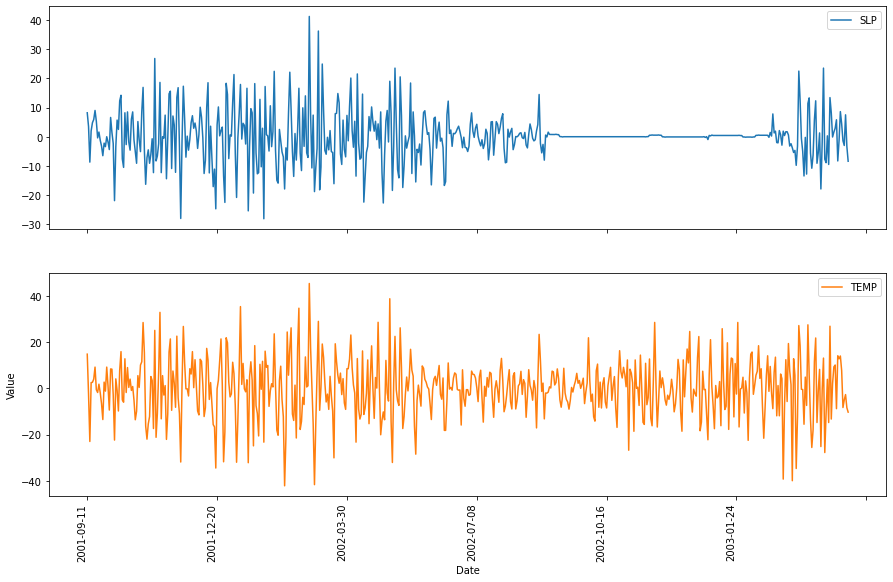

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


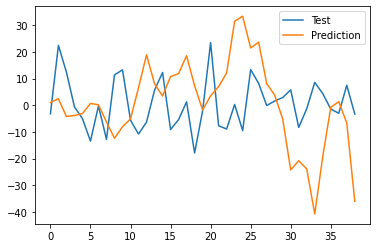

rmse 19.480249700163284
mae 15.603497094789773


In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)

pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

#<h2>LOCF</h2>

In [ ]:
missing_locf = missing_nan
missing_locf['SLP'] = missing_nan.fillna(method='ffill')
missing_vals['SLP'] = missing_locf

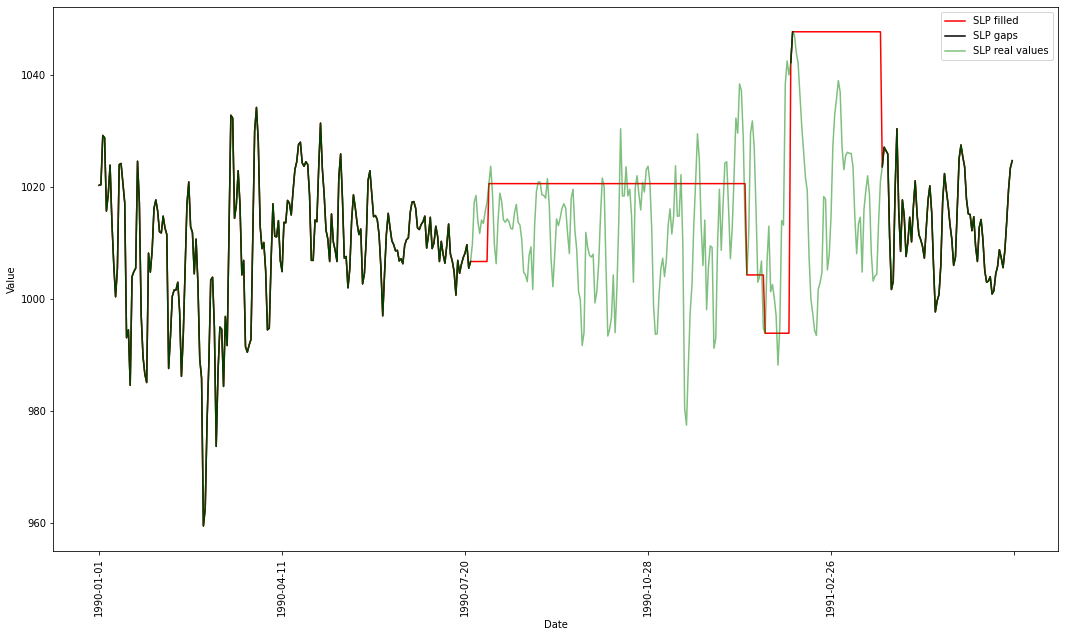

random gaps rmse:  13.184729045376717 mae:  6.604800000000007


In [ ]:
filled = random_missing.copy()
filled['SLP'] = filled.fillna(method='ffill')

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

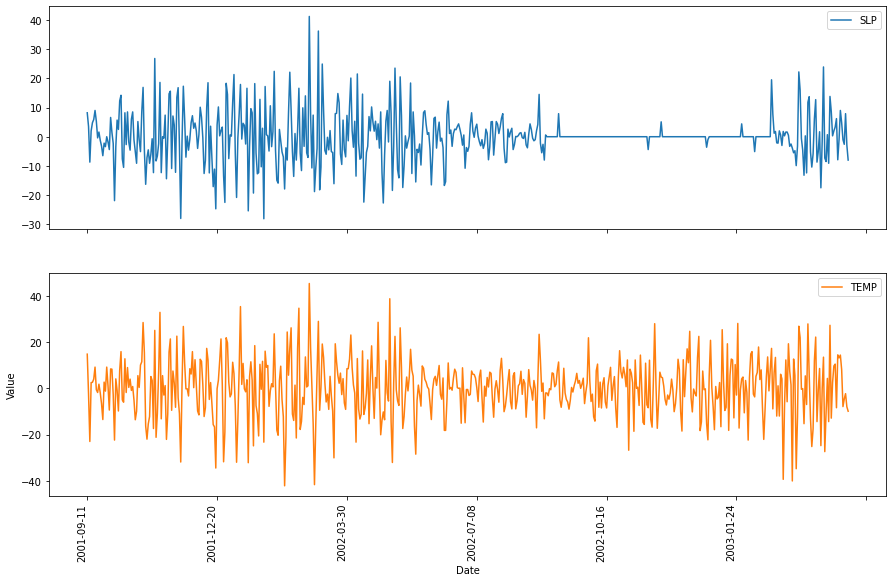

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


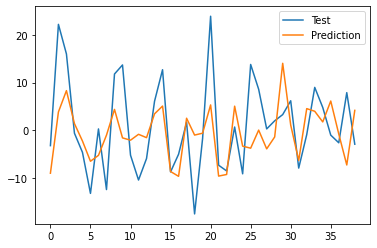

rmse 8.42549881607973
mae 6.680652435865304


In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(1)
filled_data['SLP'] = filled_data.SLP - filled_data.SLP.shift(24*3)
filled_data['TEMP'] = filled_data.SLP - filled_data.SLP.shift(365)

pressure = filled_data.SLP['2001-09-11':'2003-04-20'].values
temp = filled_data.TEMP['2001-09-11':'2003-04-20'].values

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

#lstm

In [ ]:
seq_len = 3
n = int(data.SLP.size*0.7)
scaler = MinMaxScaler(feature_range=(0,1))
n_future = 14
n_past = 90 # На основе 3 мес на 2 недели
data2 = data.copy()
data2 = data2.dropna()

data2['SLP'] = data2.SLP - data2.SLP.shift(24*3)
data2['SLP'] = data2.SLP - data2.SLP.shift(1)

train_slp = data2.iloc[100:n,0:1].values
test_slp = data2.iloc[n:n+n_past,0:1].values
test_slp_fut = data2.iloc[n+n_past:n+n_past+n_future,0:1].values

scaled_values = scaler.fit_transform(train_slp)
scaled_values_test = scaler.fit_transform(test_slp)
scaled_values_test = np.array(scaled_values_test)
scaled_values_test = np.reshape(scaled_values_test,(scaled_values_test.shape[1],scaled_values_test.shape[0],1))

In [ ]:
x_train = []
y_train = []
for i in range(0,len(scaled_values)-n_past-n_future+1):
    x_train.append(scaled_values[i:i + n_past, 0])
    y_train.append(scaled_values[i + n_past:i + n_past + n_future, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1))

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(30, return_sequences=True, input_shape=(x_train.shape[1],1))))
model.add(LSTM(30))
model.add(Dense(n_future, activation='linear'))
model.compile(optimizer='adam', loss='mse',metrics=['acc'])
model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
112/112 [==============================] - 32s 40ms/step - loss: 0.0921 - acc: 0.0701
Epoch 2/30
112/112 [==============================] - 5s 43ms/step - loss: 0.0139 - acc: 0.0597
Epoch 3/30
112/112 [==============================] - 5s 43ms/step - loss: 0.0138 - acc: 0.0766
Epoch 4/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0137 - acc: 0.0738
Epoch 5/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0136 - acc: 0.0618
Epoch 6/30
112/112 [==============================] - 5s 43ms/step - loss: 0.0137 - acc: 0.0742
Epoch 7/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0137 - acc: 0.0777
Epoch 8/30
112/112 [==============================] - 5s 44ms/step - loss: 0.0135 - acc: 0.0750
Epoch 9/30
112/112 [==============================] - 5s 45ms/step - loss: 0.0139 - acc: 0.0753
Epoch 10/30
112/112 [==============================] - 5s 44ms/step - loss: 0.0138 - acc: 0.0794
Epoch 11/30
112/112 [=================

In [ ]:
predicted = model.predict(scaled_values_test)
predicted = np.reshape(predicted,(predicted.shape[1],predicted.shape[0]))
predicted = scaler.inverse_transform(predicted)

In [ ]:
sqrt(mean_squared_error(test_slp_fut, predicted))

8.714775545017353

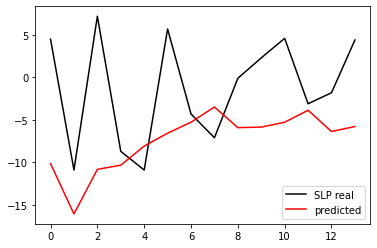

In [ ]:
plt.plot(test_slp_fut, 'black', label = 'SLP real')
plt.plot(predicted, 'red', label = 'predicted')
plt.legend()